# Random Forest Final Modeling

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

In [ ]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [ ]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [ ]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [ ]:
y_train = train['rating_category']
y_test = test['rating_category']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('classification', rf_classifier)
])

In [ ]:
param_grid_rf = {
    'feature_selection__threshold': [None, "mean"],
    'classification__n_estimators': [50, 100],
    'classification__max_depth': [None, 10, 20],
    'classification__min_samples_split': [2, 5],
    'classification__min_samples_leaf': [1, 2],
    'classification__max_features': ['auto', 'sqrt']
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1, verbose=1, error_score='raise')

# Fit it to the data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier())),
                                       ('classification',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classification__max_depth': [None, 10, 20],
                         'classification__max_features': ['auto', 'sqrt'],
                         'classification__min_samples_leaf': [1, 2],
                         'classification__min_samples_split': [2, 5],
                         'classification__n_estimators': [50, 100],
                         'feature_selection__threshold': [None, 'mean']},
             verbose=1)

In [ ]:
import joblib

# Save the trained model
joblib.dump(grid_search_rf.best_estimator_, '/content/drive/MyDrive/data/rf_model.pkl')

['/content/drive/MyDrive/data/rf_model.pkl']

In [ ]:
# Importing the required libraries
from sklearn.metrics import accuracy_score

# Function for post grid search analysis
def post_grid_search_analysis(grid_search, X_test, y_test):
    # Get the best parameters
    best_params = grid_search.best_params_

    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Get the probability scores for the test set (useful for ROC curve, etc.)
    y_score = grid_search.best_estimator_.predict_proba(X_test)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Get the best score (mean cross-validated score of the best_estimator)
    best_score = grid_search.best_score_

    results = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Test Accuracy': test_accuracy
    }

    return results

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search_rf.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
y_score_rf = grid_search_rf.best_estimator_.predict_proba(X_test)

In [ ]:
# Execute the function and store the results
results_rf = post_grid_search_analysis(grid_search_rf, X_test, y_test)

# Print the results
print(f"Random Forest Best Parameters: {results_rf['Best Parameters']}")
print(f"Random Forest Best Score: {results_rf['Best Score']}")
print(f"Random Forest Test Accuracy: {results_rf['Test Accuracy']}")

Random Forest Best Parameters: {'classification__max_depth': 20, 'classification__max_features': 'sqrt', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 2, 'classification__n_estimators': 100, 'feature_selection__threshold': 'mean'}
Random Forest Best Score: 0.6155810147299509
Random Forest Test Accuracy: 0.6215295966474594


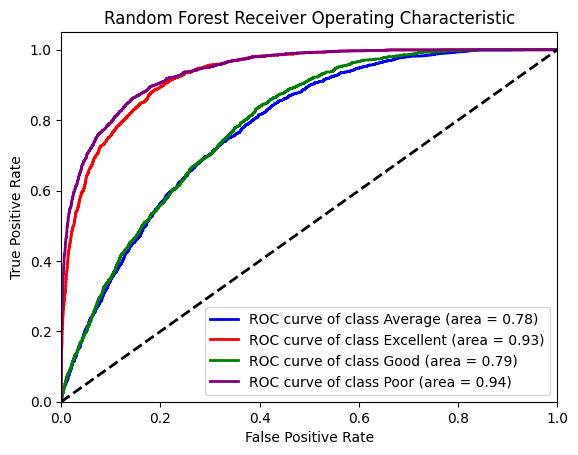

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
rf_report = classification_report(y_test, y_pred_rf, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
rf_report_df = pd.DataFrame(rf_report).transpose()

In [ ]:
rf_report_df

,precision,recall,f1-score,support
Average,0.495982,0.454976,0.474595,1899.00000
Excellent,0.744411,0.699205,0.721100,1762.00000
Good,0.515820,0.543434,0.529267,1980.00000
Poor,0.731073,0.788972,0.758920,1995.00000
accuracy,0.621530,0.621530,0.621530,0.62153
macro avg,0.621821,0.621647,0.620971,7636.00000
weighted avg,0.619871,0.621530,0.619936,7636.00000


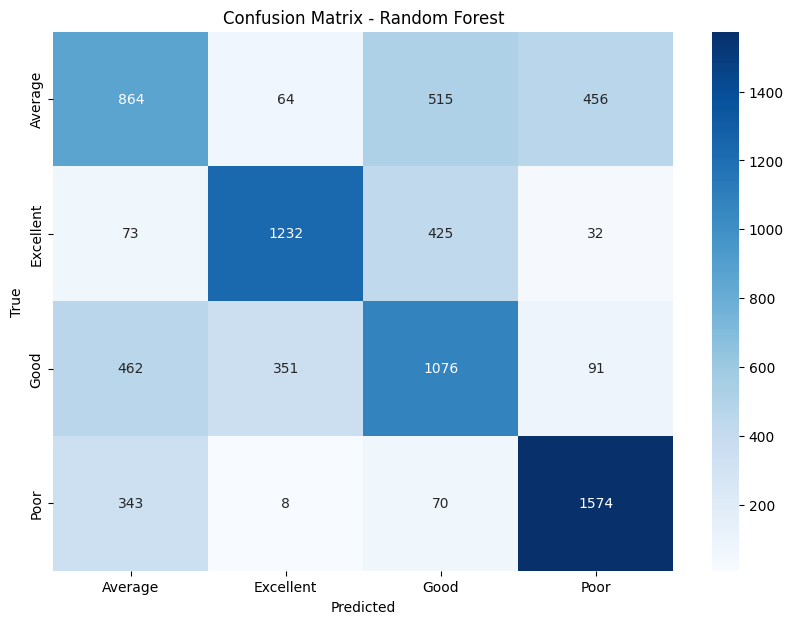

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()
